#### Importing all Libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np

from math import nan

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


#### Reading Datasets

In [7]:
df = pd.read_csv('E:\OneDrive - dada\DS Projects\House price prediction\data\Bengaluru_House_Data.csv')
df.head()
df.shape

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


(13320, 9)

#### Data Cleaning 

In [8]:
df.isna().sum()
df.dtypes

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

area_type        object
availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
dtype: object

In [9]:
#filling na with anantpura in location
# data[df['location'].isna() == True]
# df[df['society'] == 'Grare S']
df['location'].fillna('Anantapura',inplace=True)

#filling na with median in size
df['size'] = df['size'].astype(str)
df['bhk'] = df['size'].str[0]
df2 = df.drop(['size'],axis=1)
df2.bhk.replace('n',nan,inplace=True)
df2.bhk.fillna(df2.bhk.median(),inplace=True)
df2['bhk'] = df2['bhk'].astype(float)

# dropping society due to 41% missing values
df3 = df2.drop(['society'],axis =1)

#filling na in bath based on na in bedrooms
df3.loc[(df3['bath'].isna()==True),'bath'] = df3['bhk'] - 1
df3.bath.replace({0:1},inplace = True)

#filling na in balcony with median
df3.loc[(df3['balcony'].isna()==True),'balcony'] = df3.balcony.median()
df3.loc[df3['bhk'] == 1,'balcony'] = 1


In [10]:
df3.isna().sum()
df3.head(2)
df3.shape

area_type       0
availability    0
location        0
total_sqft      0
bath            0
balcony         0
price           0
bhk             0
dtype: int64

,area_type,availability,location,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,19-Dec,Electronic City Phase II,1056,2.0,1.0,39.07,2.0
1,Plot Area,Ready To Move,Chikka Tirupathi,2600,5.0,3.0,120.00,4.0


(13320, 8)

#### Feature Engineering

In [11]:
def convert_to_num(x):
    numbers = x.split('-')
    if len(numbers) ==2:
        return((float(numbers[0])+float(numbers[1]))/2)
    else:
        try:
            return float(x)
        except:
            return None

In [12]:
df3.groupby(['area_type'])['price'].mean()

#label encoding  - area type
df4 = df3.copy()
df4.area_type.replace({'Carpet  Area':1,'Super built-up  Area':2,'Built-up  Area':3,'Plot  Area':4},inplace=True)


# creating additional features from availability
df4['is_avail'] = np.where(((df4['availability'] == 'Ready To Move')|(df4['availability'] =='Immediate Possession')),1,0)
df4 = df4.drop(['availability'],axis =1)


# extracting total_sqft
df4['total_sqft'] = df3['total_sqft'].apply(lambda x: convert_to_num(x))
df4.dropna(axis = 0,inplace=True)

#extracting location
loc_stats = df4.groupby(['location'])['location'].agg('count').sort_values(ascending=False)
sparse_loc = loc_stats[loc_stats<=10]
df4['location'] = df4.location.apply(lambda x: 'others' if x in sparse_loc else x)


#price per sqft
df4['price_per_sqft'] = round(df4['price']*100000/df4['total_sqft'],2)

#dropping duplicates 
df4 = df4.drop_duplicates()
df4.shape



df4.head(4)
df4.shape

area_type
Built-up  Area          104.285498
Carpet  Area             89.502356
Plot  Area              208.495486
Super built-up  Area     92.971757
Name: price, dtype: float64

(12548, 9)

,area_type,location,total_sqft,bath,balcony,price,bhk,is_avail,price_per_sqft
0,2,Electronic City Phase II,1056.0,2.0,1.0,39.07,2.0,0,3699.81
1,4,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4.0,1,4615.38
2,3,Uttarahalli,1440.0,2.0,3.0,62.00,3.0,1,4305.56
3,2,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3.0,1,6245.89


(12548, 9)

#### Outlier Detection & Removal

In [13]:
def pps_outliers(data):
    fin_df = pd.DataFrame()
    temp_df = data.groupby('location').agg({'price_per_sqft':'count'})
    temp_df['mean_pps'] = data.groupby('location').agg({'price_per_sqft':'mean'})
    temp_df['std_pps'] = data.groupby('location').agg({'price_per_sqft':'std'})
    temp_df['min_pps'] = temp_df['mean_pps']-temp_df['std_pps']
    temp_df['max_pps'] = temp_df['mean_pps']+temp_df['std_pps']
    temp_df = temp_df.reset_index()
    for loc in temp_df['location']:
        #min & Max
        min_val = float(temp_df[temp_df['location']==loc]['min_pps'])
        max_val = float(temp_df[temp_df['location']==loc]['max_pps'])
        loc_df = data[data['location']==loc]
        loc_df = loc_df[(loc_df['price_per_sqft']>=min_val)&(loc_df['price_per_sqft']<=max_val)].reset_index(drop=True)
        fin_df = fin_df.append(loc_df,ignore_index=True)

    return(fin_df)

def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')




In [14]:
df5 = df4.copy()

# total sqft  & BHK
df5 = df5[~(df5['total_sqft']/df5['bhk'] < 300)].reset_index(drop=True)
df5.shape

#removing outliers in pps
df5 = pps_outliers(df5)
df5.shape

#removing outliers from bathroom
df5 = df5[df5['bath']<=df5['bhk']+2].reset_index(drop=True)
df5.shape

#bhk outliers
df5 = remove_bhk_outliers(df5)
df5.shape

# One Hot Encoding
loc_dummies = pd.get_dummies(df5.location)
df5 = pd.concat([df5,loc_dummies.drop('others',axis='columns')],axis='columns')
df5.drop(columns = ['location'],axis =1,inplace=True)

df5.head()
df5.shape

(11833, 9)

(9773, 9)

(9757, 9)

(7001, 9)

,area_type,total_sqft,bath,balcony,price,bhk,is_avail,price_per_sqft,Devarachikkanahalli,1st Block Jayanagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,2,1250.0,2.0,2.0,40.0,2.0,1,3200.00,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4,1200.0,2.0,2.0,83.0,2.0,1,6916.67,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1170.0,2.0,2.0,40.0,2.0,1,3418.80,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1425.0,2.0,2.0,65.0,3.0,1,4561.40,1,0,...,0,0,0,0,0,0,0,0,0,0
5,2,947.0,2.0,2.0,43.0,2.0,1,4540.65,1,0,...,0,0,0,0,0,0,0,0,0,0


(7001, 248)

#### Model Development - Base Model

In [15]:
df5.area_type.value_counts()

2    5033
3    1326
4     601
1      41
Name: area_type, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [17]:
X = df5.drop(['price','price_per_sqft'],axis =1).values
y = df5['price'].values

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)
print(f'Shape of train dataset:{X_train.shape}')
print(f'Shape of test dataset:{X_test.shape}')

Shape of train dataset:(5600, 246)
Shape of test dataset:(1401, 246)


In [19]:
# Scaling
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [20]:
# Linear regression

lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_sc,y_train)

lr.score(X_test_sc,y_test)

LinearRegression()

0.8523792364991514

In [21]:
# Cross Validation

cv_fold = ShuffleSplit(n_splits= 5,test_size=0.2,random_state=42)

cross_val_score(lr,X_train_sc,y_train,cv = cv_fold)

array([0.85137763, 0.8638926 , 0.79463243, 0.83743359, 0.81013807])

#### Hyperparameter Tuning

In [22]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

In [23]:
# Scaling whole dataset
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [24]:
models = {
    'linear_reg':{
        'model' : LinearRegression(),
        'params':{'normalize':[True,False] }
    },
    'lasso':{
        'model':Lasso(),
        'params': {'alpha':[1,2],'selection':['random','cyclic']}
    },
    'dt':{
        'model':DecisionTreeRegressor(),
        'params':{'criterion':['mse','friedman_mse'],'splitter':['best','random']}
    }
}

In [25]:
scores =list()
cv_fold = ShuffleSplit(n_splits= 5,test_size=0.2,random_state=42)
for model_name, para in models.items():
    grid_cv = GridSearchCV(para['model'],para['params'],cv = cv_fold,return_train_score=False,scoring='r2')
    grid_cv.fit(X_sc,y)
    scores.append(
        {
        'model':model_name,
        'best_score':grid_cv.best_score_,
        'best_params':grid_cv.best_params_,
    }
    )
score_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None),
             estimator=LinearRegression(),
             param_grid={'normalize': [True, False]}, scoring='r2')

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None),
             estimator=Lasso(),
             param_grid={'alpha': [1, 2], 'selection': ['random', 'cyclic']},
             scoring='r2')

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None),
             estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse', 'friedman_mse'],
                         'splitter': ['best', 'random']},
             scoring='r2')

In [26]:
score_df

,model,best_score,best_params
0,linear_reg,0.858413,{'normalize': True}
1,lasso,0.831453,"{'alpha': 1, 'selection': 'cyclic'}"
2,dt,0.752325,"{'criterion': 'mse', 'splitter': 'best'}"


In [27]:
# lr_model = LinearRegression(normalize=True)
# lr_model.fit(X_sc,y)
# y_pred = lr_model.predict(X_test_sc)


In [28]:
y_pred = grid_cv.best_estimator_.predict(X_test_sc)

#### Model Evaluation

In [29]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [30]:
def evaluate_model(true,predicted):
    print("MAE=",mean_absolute_error(true,predicted))
    print("MSE=",mean_squared_error(true,predicted))
    print("RMSE=",np.sqrt(mean_squared_error(true,predicted)))
    r2 = r2_score(true,predicted)
    print(f'R2={r2}')
    plt.figure(figsize=(10,5))
    sns.scatterplot(x=true,y=predicted)
    plt.plot(true,true,'r')
    return()

MAE= 11.000039600398807
MSE= 705.3423258035896
RMSE= 26.55828168017633
R2=0.8893021871288771


()

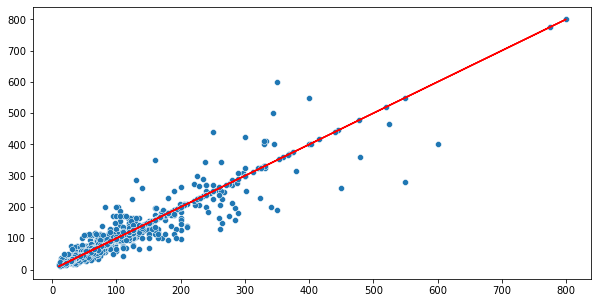

In [31]:
evaluate_model(y_test,y_pred)

In [32]:
fin_model = grid_cv.best_estimator_
fin_scaler = sc

#### Single Prediction

In [33]:
def predict_price(location,area_type,sqft,bhk,bath,balcony,ready_to_move):
    ref_dict = {
        'area_type':{'Carpet  Area':1,'Super built-up  Area':2,'Built-up  Area':3,'Plot  Area':4},
        'ready_to_move':{'yes':1,'no':0}
        }

    loc_index = np.where(df5.drop(['price','price_per_sqft'],axis=1).columns==location)[0][0]
    x = np.zeros(len(df5.drop(['price','price_per_sqft'],axis=1).columns))
    x[0] = ref_dict.get('area_type').get(area_type)
    x[1] = sqft
    x[2] = bath
    x[3] = balcony
    x[4] = bhk
    x[5] = ref_dict.get('ready_to_move').get(ready_to_move)
    if loc_index >=0:
        x[loc_index] = 1
    x = x.reshape(1,-1)
    x_sc = sc.transform(x)

    pred = fin_model.predict(x_sc)[0] * 100000

    return(pred)

In [34]:
predict_price('1st Phase JP Nagar','Super built-up  Area',1230, 2, 2,1,'yes')
predict_price('Vijayanagar','Super built-up  Area',2000, 4,1,1,'no')
predict_price('Indira Nagar','Super built-up  Area',1280, 3, 2,2,'yes')

5800000.0

16000000.0

16800000.0

##### Export Scaler, Model & Features info

In [35]:
import pickle as pkl
import json

In [37]:
with open('bng_price_model.pkl','wb') as f:
    pkl.dump(fin_model,f)

with open('bng_price_scaler.pkl','wb') as f:
    pkl.dump(fin_scaler,f)

In [38]:
columns = {
    'features':[col.lower() for col in df5.drop(['price','price_per_sqft'],axis=1).columns]
}

with open('features.json','w') as f:
    f.write(json.dumps(columns))

4027

:)